In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from utils import EnhancerDataset, split_dataset, train_model, regression_model_plot
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.nn.modules.activation as activation
import sys
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import interpretation
import seaborn as sns
import matplotlib.pyplot as plt
import tools
import logomaker
import os
import pickle

sys.path.append('../model')  
from model import ConvNetDeep, DanQ, ExplaiNN,ConvNetDeep2, ExplaiNN2, ExplaiNN3

### Train Model

In [2]:
# Directory to save the result
seed = 42 
batch = 322
num_cnns = 90
learning_rate= 2e-4
target_labels = ["GFP+", "GFP-"]
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_both_results'

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train, test = split_dataset(df, split_type='random', cutoff = 0.8, seed = seed)

# Process datasets
train = EnhancerDataset(train, label_mode='both', scale_mode = 'none')
test = EnhancerDataset(test, label_mode='both', scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=True)

#input_model = ExplaiNN2(num_cnns = 256, input_length = 608, num_classes = 2, 
#                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
#                 fc_filter1 = 20, fc_filter2 = 1, drop_out = 0.3, weight_path = None)# Training

input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 2, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, device  = train_model(input_model, train_loader, test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/72, Loss: 77.3603
Epoch 1/200: Train Loss: 71.3171 , Test Loss: 67.5008
------------------------Evaluation------------------------
Label 1: MSE=70.8138, RMSE=8.4151, MAE=8.4091, R^2=-901.6230, Pearson=0.2710, Spearman=0.2542
Label 2: MSE=64.1824, RMSE=8.0114, MAE=8.0063, R^2=-1259.6348, Pearson=0.1274, Spearman=0.1279
Overall (Flattened): MSE=67.4981, RMSE=8.2157, MAE=8.2077, R^2=-1006.9797, Pearson=0.0684, Spearman=0.0637
----------------------------------------------------------
Epoch 2/200, Step 1/72, Loss: 65.5511
Epoch 2/200: Train Loss: 60.7588 , Test Loss: 58.1206
------------------------Evaluation------------------------
Label 1: MSE=61.2327, RMSE=7.8251, MAE=7.8196, R^2=-779.4978, Pearson=0.3497, Spearman=0.3305
Label 2: MSE=55.0045, RMSE=7.4165, MAE=7.4113, R^2=-1079.3674, Pearson=0.1657, Spearman=0.1684
Overall (Flattened): MSE=58.1186, RMSE=7.6236, MAE=7.6155, R^2=-866.9111, Pearson=0.1099, Spearman=0.1012
--

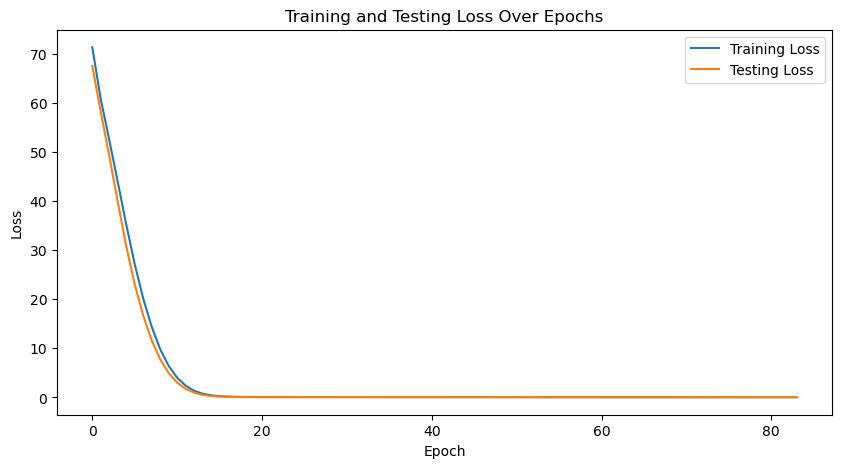

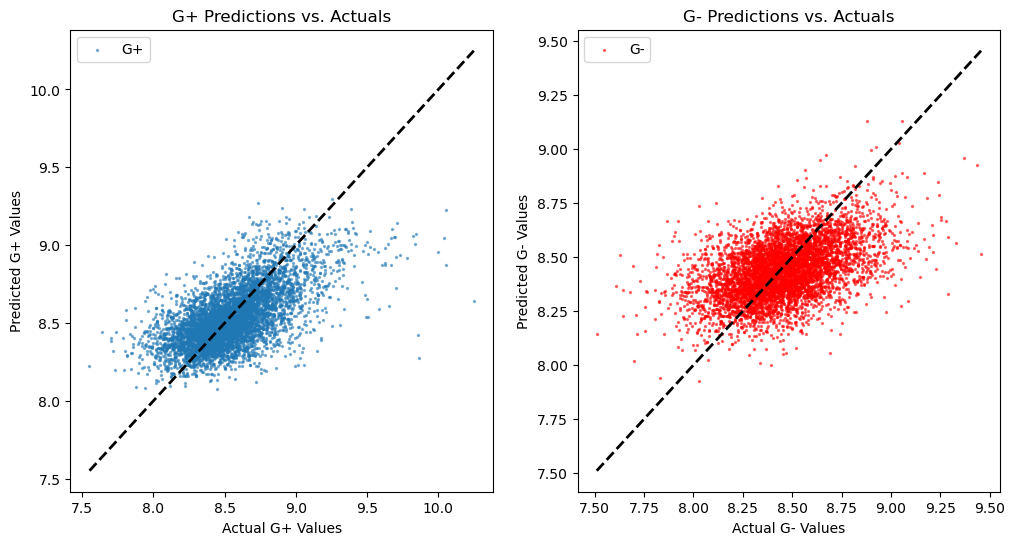

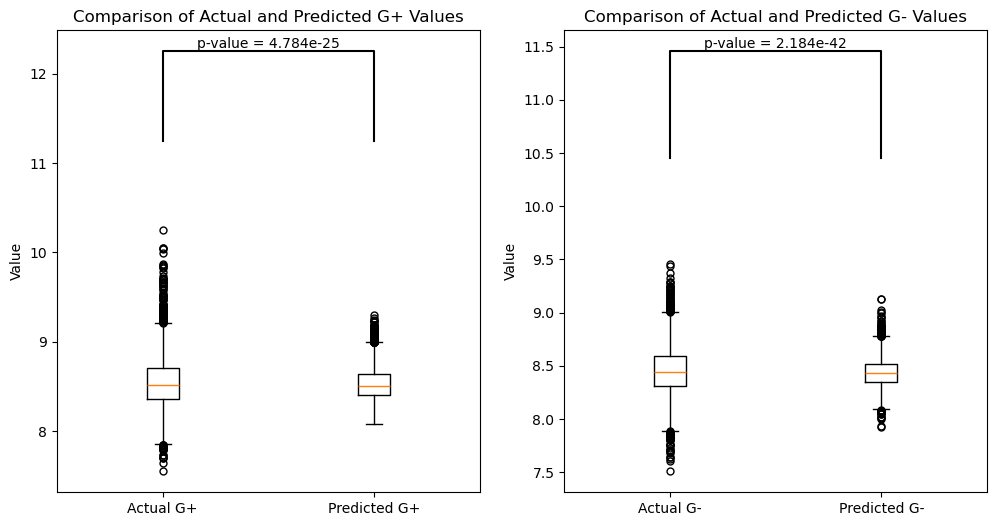

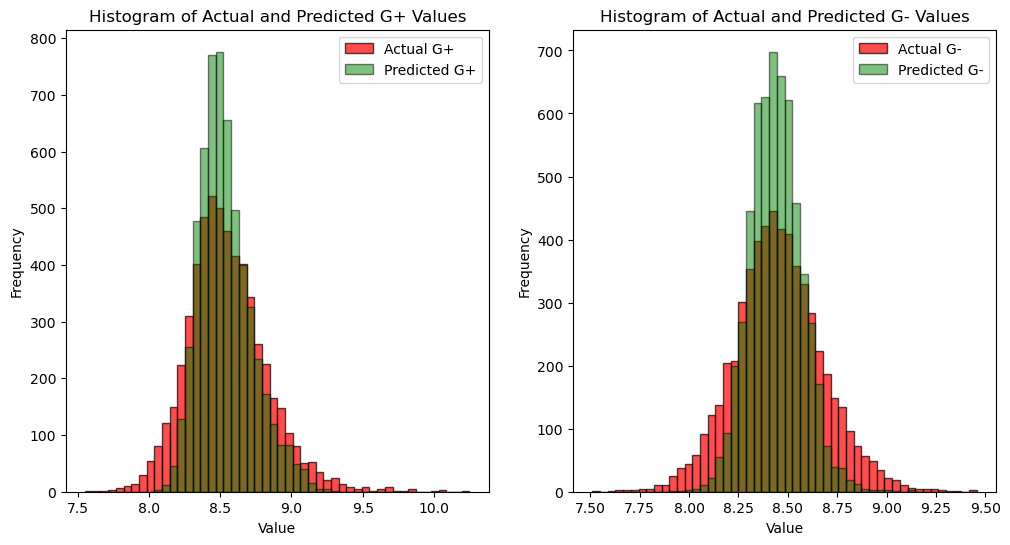

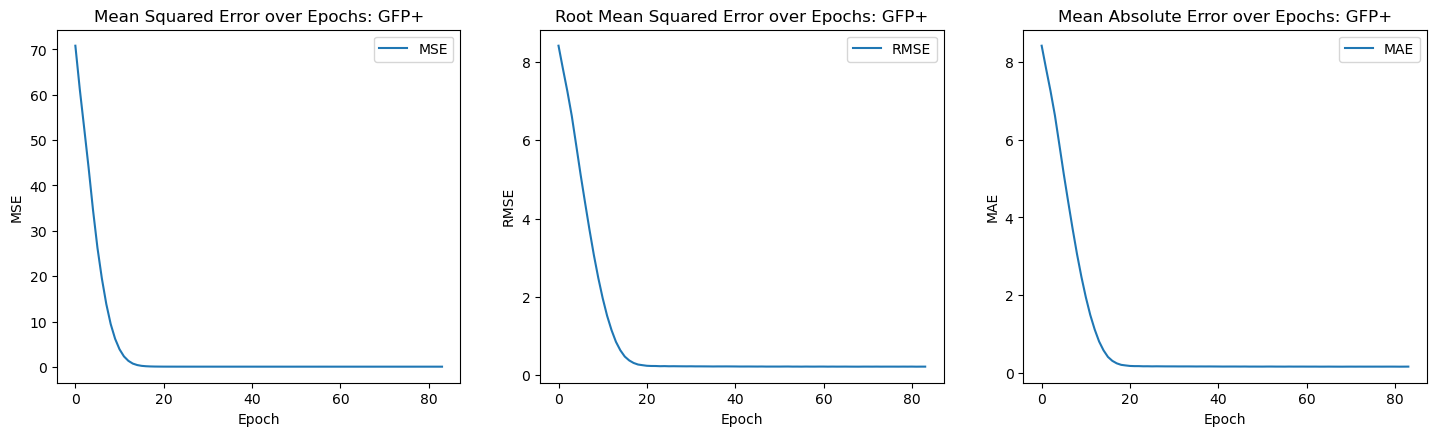

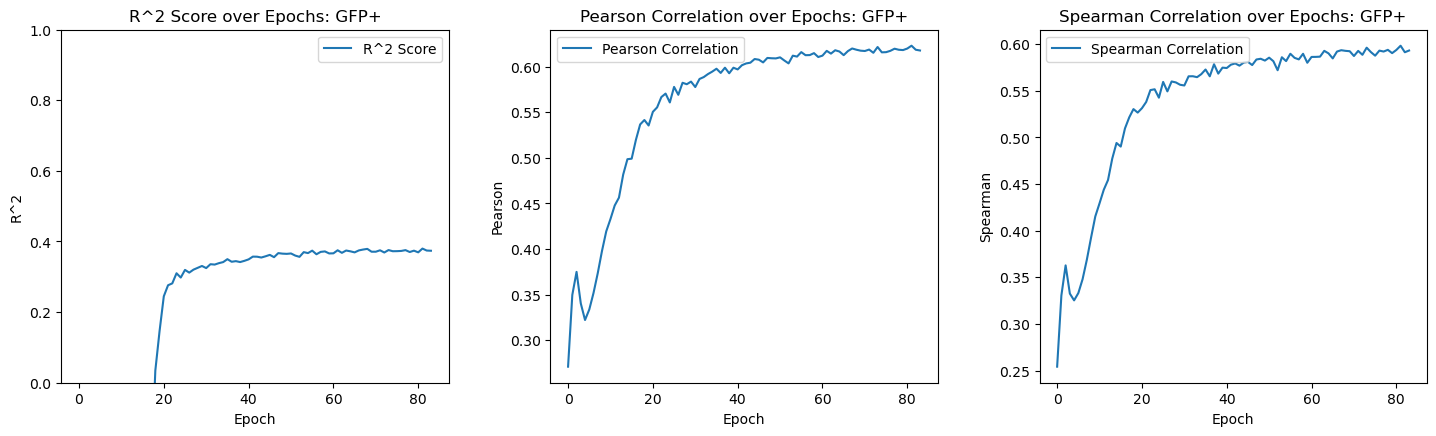

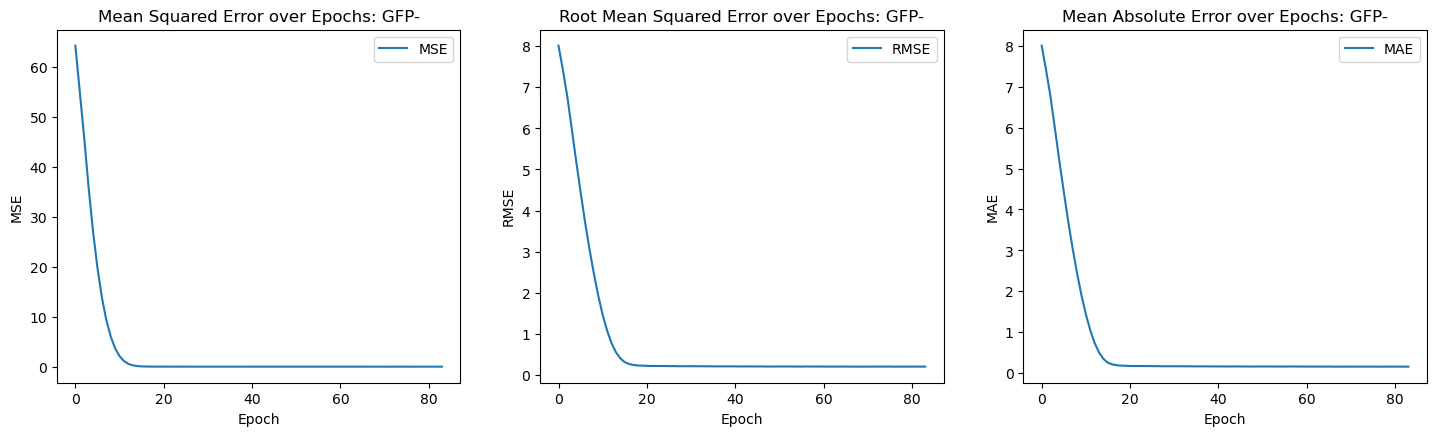

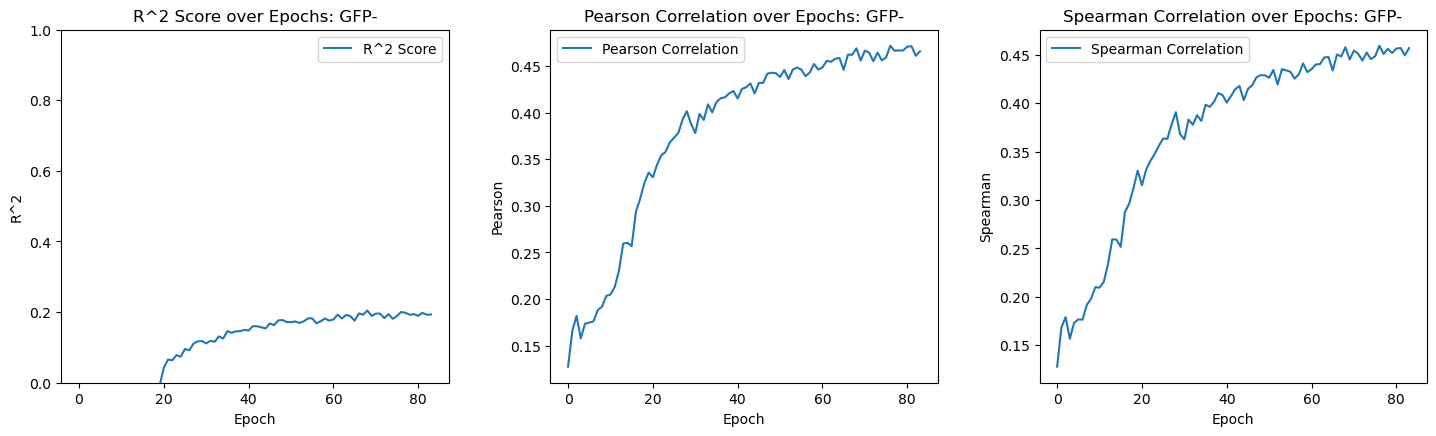

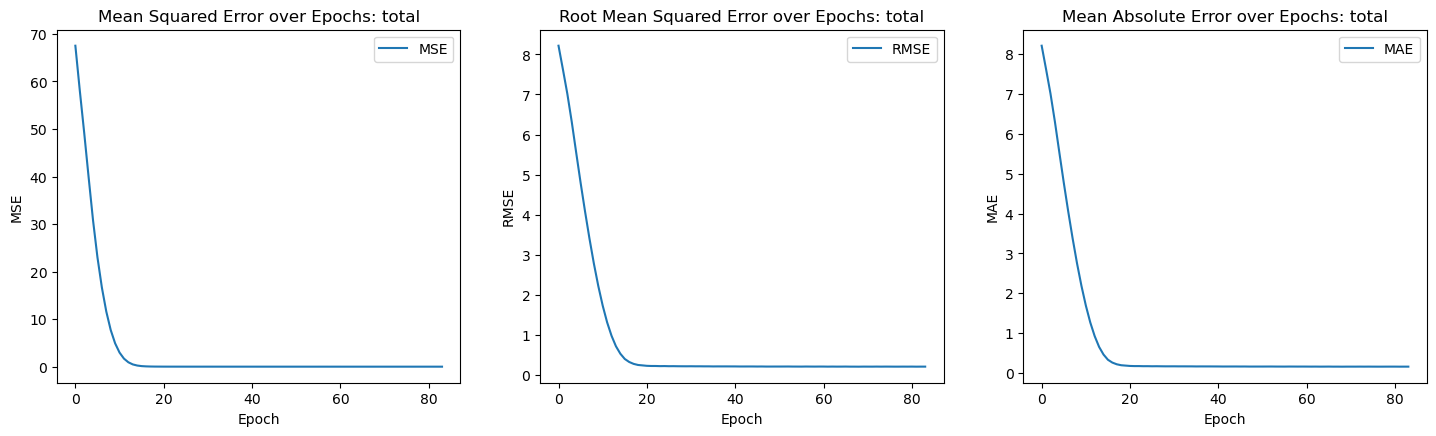

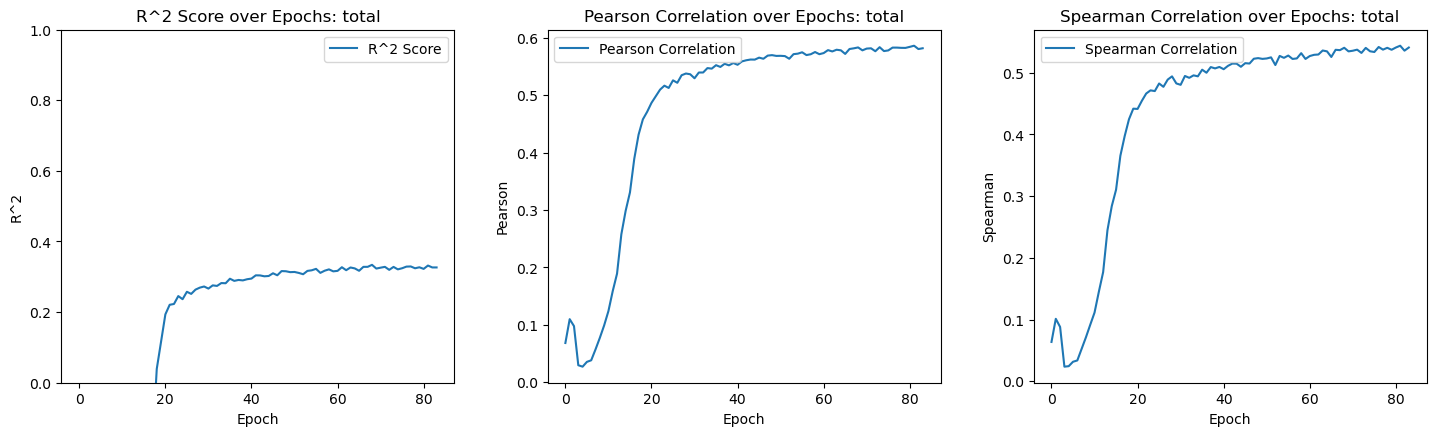

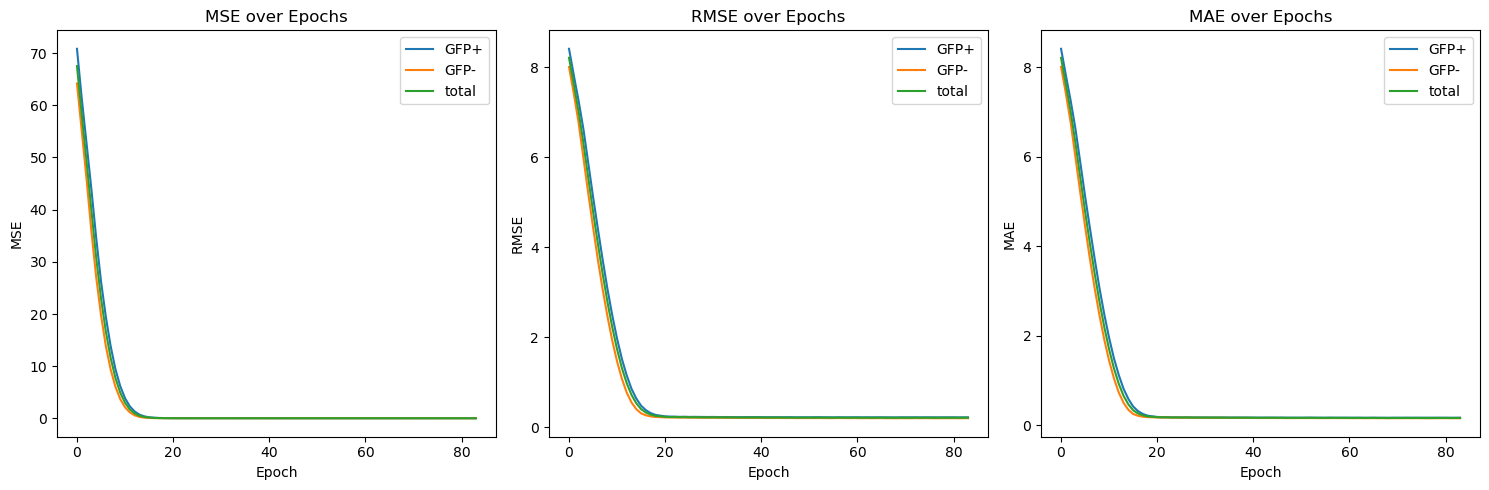

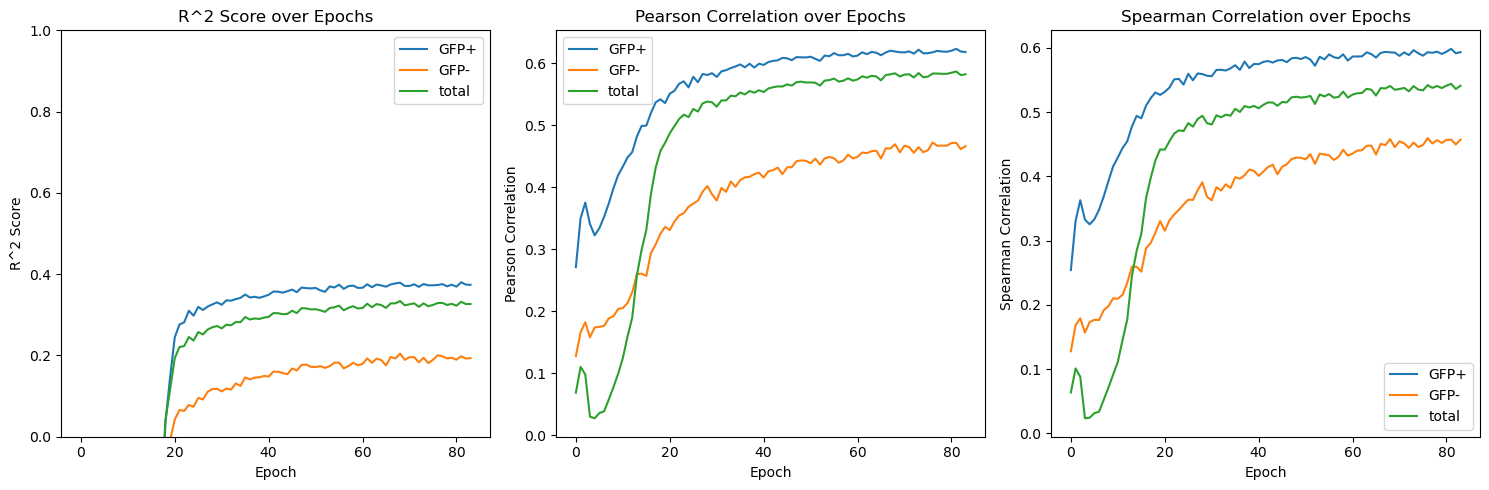

MSE: 0.0451, RMSE: 0.2124, MAE: 0.1614
R^2: 0.3265, Pearson Correlation: 0.5820, Spearman Correlation: 0.5409


In [3]:
best_r2_epoch = 69
model_path = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_both_results/model_epoch_{best_r2_epoch}.pth'
mse, rmse, mae, r2, pearson_corr, spearman_corr = regression_model_plot(
    model, test_loader, train_losses_by_batch, test_losses_by_batch, 
    device, results, label_mode = "both", save_plot = False, dir_path = None, model_path = model_path, best_model=best_r2_epoch)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}, Pearson Correlation: {pearson_corr:.4f}, Spearman Correlation: {spearman_corr:.4f}")

### Interpretation

In [5]:
best_r2_epoch = 77
filter_size = 19
seed = 42 
batch = 322
num_cnns = 90
learning_rate= 2e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
explainn = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 2, 
                 filter_size = filter_size, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training
explainn.to(device)  

weight_file = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_both_results/model_epoch_{best_r2_epoch}.pth'
explainn.load_state_dict(torch.load(weight_file))
explainn.eval()

ExplaiNN3(
  (linears): Sequential(
    (0): Conv1d(360, 90, kernel_size=(19,), stride=(1,), groups=90)
    (1): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ExpActivation()
    (3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Unsqueeze()
    (6): Conv1d(7560, 9000, kernel_size=(1,), stride=(1,), groups=90)
    (7): BatchNorm1d(9000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(9000, 90, kernel_size=(1,), stride=(1,), groups=90)
    (11): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (final): Linear(in_features=90, out_features=2, bias=True)
)

In [6]:
best_r2_epoch = 77
filter_size = 19
seed = 42 
batch = 322
num_cnns = 90
learning_rate= 2e-4
# Load dataset as a pandas dataframe
df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')
# Prepare features and labels:
# --(Features): Transform all sequences into one-hot encodings
# --(Labels): Use GFP+ and GFP- as labels
dataset = EnhancerDataset(df, label_mode='both', scale_mode = 'none')
# Prepare dataloader
dataset = DataLoader(dataset=dataset, batch_size=batch, shuffle=False)

# Running get_explainn_predictions function to get predictions and true labels for all sequences in the given data loader
predictions, labels = interpretation.get_explainn_predictions(dataset, explainn, device, isSigmoid=False)
print(predictions.shape)

(28800, 2)


Number of samples before filtering: 28800
torch.Size([21653, 4, 608])
torch.Size([21653, 2])
Number of samples after filtering: 21653


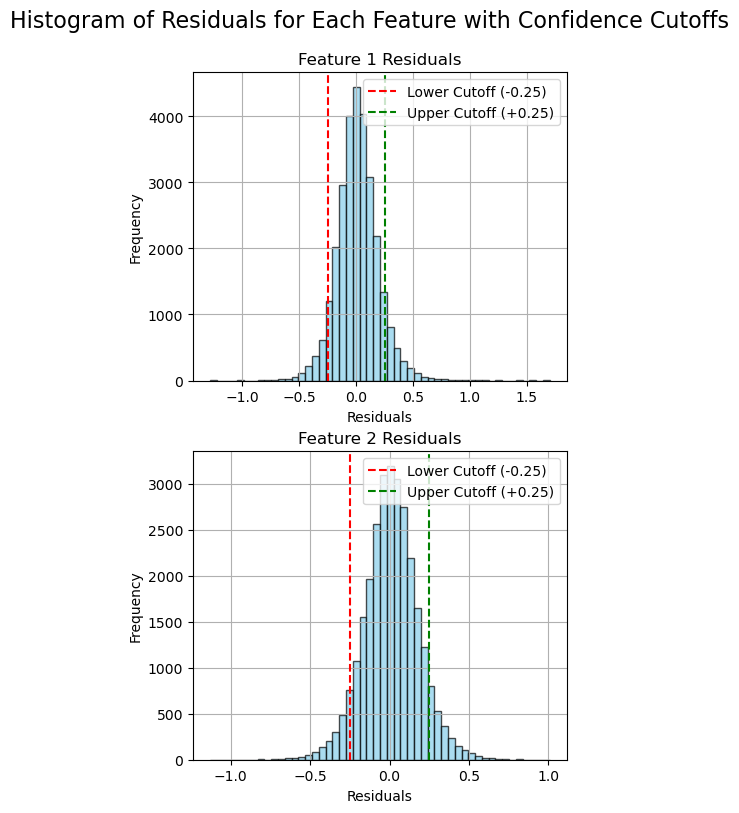

In [7]:
# Load dataset as a pandas dataframe
df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')
# Prepare features and labels:
# --(Features): Transform all sequences into one-hot encodings
# --(Labels): Use GFP+ and GFP- as labels
dataset = EnhancerDataset(df, label_mode='both', scale_mode = 'none')
# Prepare dataloader
dataset = DataLoader(dataset=dataset, batch_size=batch, shuffle=False)

# Running get_explainn_predictions function to get predictions and true labels for all sequences in the given data loader
predictions, labels = interpretation.get_explainn_predictions(dataset, explainn, device, isSigmoid=False)

"""Now filter out low confident predictions"""
# Calculate absolute residuals
residuals = np.abs(labels - predictions)

# Define the upper bound of residuals
upper_bound = 0.25

# Create a mask for filtering out samples with low confident precition (abs(residual) > upper_bound)
mask = (residuals <= upper_bound).all(axis=1)

# Get sequences and labels from dataset
data_inp = []
data_out = []
# Iterate over the DataLoader
for batch_features, batch_labels in dataset:
    data_inp.append(batch_features)
    data_out.append(batch_labels)
# Concatenate all the batches into single tensors
data_inp = torch.cat(data_inp, dim=0)
data_out = torch.cat(data_out, dim=0)

# Use the mask to filter the predictions and labels
print(f'Number of samples before filtering: {len(data_inp)}')
data_inp = data_inp[mask]
data_out = data_out[mask]
print(data_inp.shape)
print(data_out.shape)

print(f'Number of samples after filtering: {len(data_inp)}')

# Create new dataloader with filtered high confident samples
dataset = torch.utils.data.TensorDataset(data_inp, data_out)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch, shuffle=False,)

# Plot histogram of residuals with adjusted cutoff lines
# 1. Compute residuals (not absolute)
residuals = labels - predictions

# 2. Define bounds for plotting
upper_bound = 0.25
lower_bound = -0.25

# 3.Plotting the histograms for each feature
fig, axes = plt.subplots(nrows=predictions.shape[1], ncols=1, figsize=(5, 4*predictions.shape[1]))
fig.tight_layout(pad=3.0)

# Title for the entire figure
fig.suptitle('Histogram of Residuals for Each Feature with Confidence Cutoffs', fontsize=16, y=1.02)

for i in range(predictions.shape[1]):
    ax = axes[i]
    ax.hist(residuals[:, i], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax.axvline(x=lower_bound, color='red', linestyle='--', label=f'Lower Cutoff (-0.25)')
    ax.axvline(x=upper_bound, color='green', linestyle='--', label=f'Upper Cutoff (+0.25)')
    ax.set_title(f'Feature {i+1} Residuals')
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True)

plt.show()

In [8]:
""" ！！！！！！！！！！！！
You don't need to run this if you already calculated activations and pwms before
"""
# Get weights from activation layer
activations = interpretation.get_explainn_unit_activations(data_loader, explainn, device)
print(f"Activations have shape: {activations.shape}")
# Save activations
activation_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_both_Activations.npy'
np.save(activation_path, activations)

# Get torch,  one-hot encoding sequences from data_loader
sequences = []
# Iterate over the DataLoader
for batch in data_loader:
    batch_sequences = batch[0]  
    sequences.append(batch_sequences)
sequences = torch.cat(sequences, dim=0)

# Define filter size. This parameter should be consistent with filter_size used in ExplaiNN
filter_size = 19
pwms = interpretation.get_pwms_explainn(activations, sequences, filter_size)

# Save pwms
pwm_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_both_pwms.npy'
np.save(pwm_path, pwms)

100%|████████████████████| 68/68 [00:04<00:00, 14.53it/s]


Activations have shape: (21653, 90, 590)


100%|████████████████████| 90/90 [00:36<00:00,  2.49it/s]


In [9]:
pwm_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_both_pwms.npy'
activation_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_both_Activations.npy'
pwm_name = '/pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_both_TFBS.meme'
activations = np.load(activation_path)
print(f"Activations have shape: {activations.shape}")
pwms = np.load(pwm_path)
print(f"PWMs have shape: {pwms.shape}")
interpretation.pwm_to_meme(pwms, pwm_name)

Activations have shape: (21653, 90, 590)
PWMs have shape: (90, 4, 19)
Saved PWM File as : /pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_both_TFBS.meme


In [ ]:
# Running tomtom to compare 100CNN_TFBS.meme with JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt
#%cd /pmglocal/ty2514/Enhancer
#!python ExplaiNN/scripts/utils/tomtom.py Enhancer/data/100CNN_TFBS.meme ExplaiNN/data/JASPAR/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt -o Enhancer/tomtom_results/tomtom_CAM_100


In [12]:
tomtom_results = pd.read_csv("/pmglocal/ty2514/Enhancer/Enhancer/tomtom_2024results/tomtom_CAM_90_both/tomtom.tsv",
                                        sep="\t",comment="#")
filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]
tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]
cisbp_motifs = {}
with open("/pmglocal/ty2514/Enhancer/ExplaiNN/data/JASPAR/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt") as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            cisbp_motifs[name_m] = motif

filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]
    if len(target_id) > 5:
        target_id = target_id[:5]
    # Join Unique annotations by '/'
    ann = "/".join({cisbp_motifs[i]: i for i in target_id.values})
    annotation[f] = ann

annotation = pd.Series(annotation)
annotation

filter2             CTCF/ZNF354A/PRDM9/PPARA::RXRA
filter3                      CTCF/ZNF354A/MAF/MAFA
filter5                                       CTCF
filter7                                     ZNF530
filter9                                       CTCF
filter10           CTCF/ZNF354A/PPARA::RXRA/ZNF213
filter14                        CTCF/ZNF454/TFAP2C
filter18                 CTCF/ZBTB24/ZNF320/ZNF454
filter20                              CTCF/ZNF354A
filter21                  CTCF/PPARA::RXRA/ZNF354A
filter22    CTCF/RARA::RXRG/RARA::RXRA/PPARA::RXRA
filter29                  CTCF/Tfcp2l1/PPARA::RXRA
filter30                  CTCF/ZNF354A/Spi1/ZNF675
filter31                                      CTCF
filter32                                      CTCF
filter33      CTCF/ZNF354A/PPARA::RXRA/Pparg::Rxra
filter37       CTCF/ZNF354A/RARA::RXRG/PPARA::RXRA
filter44           CTCF/ZNF354A/Pparg::Rxra/ZBTB24
filter47                 CTCF/PRDM9/ZNF354A/ZNF184
filter48            CTCF/PPARA:

In [13]:
weights = explainn.final.weight.detach().cpu().numpy()
print(weights.shape)
num_cnns = 90
filters = ["filter"+str(i) for i in range(num_cnns)]
target_labels = ["GFP+","GFP-"]

for i in annotation.keys():
    filters[int(i.split("filter")[-1])] = annotation[i]

weight_df = pd.DataFrame(weights, target_labels, columns=filters)
weight_df.shape
weight_df

(2, 90)


,filter0,filter1,CTCF/ZNF354A/PRDM9/PPARA::RXRA,CTCF/ZNF354A/MAF/MAFA,filter4,CTCF,filter6,ZNF530,filter8,CTCF,...,filter80,filter81,filter82,CTCF/PRDM9/ZNF320/ZNF682,filter84,CTCF/ZNF354A/ZNF530/PRDM9,filter86,filter87,CTCF/ZNF354A/PPARA::RXRA,CTCF/ZNF354A
GFP+,0.043966,0.088155,0.156073,0.116647,-0.018976,0.207601,0.128595,0.200716,0.046915,0.225288,...,0.173149,0.206423,0.007190,0.209271,0.163825,0.178916,0.214093,0.199905,0.238347,0.172239
GFP-,0.242826,-0.001843,0.192493,0.198193,-0.022864,0.237096,0.116819,0.160922,0.135461,0.123734,...,0.075638,0.208474,-0.015661,0.152514,0.126496,0.167853,0.107219,0.123136,0.156728,0.158236


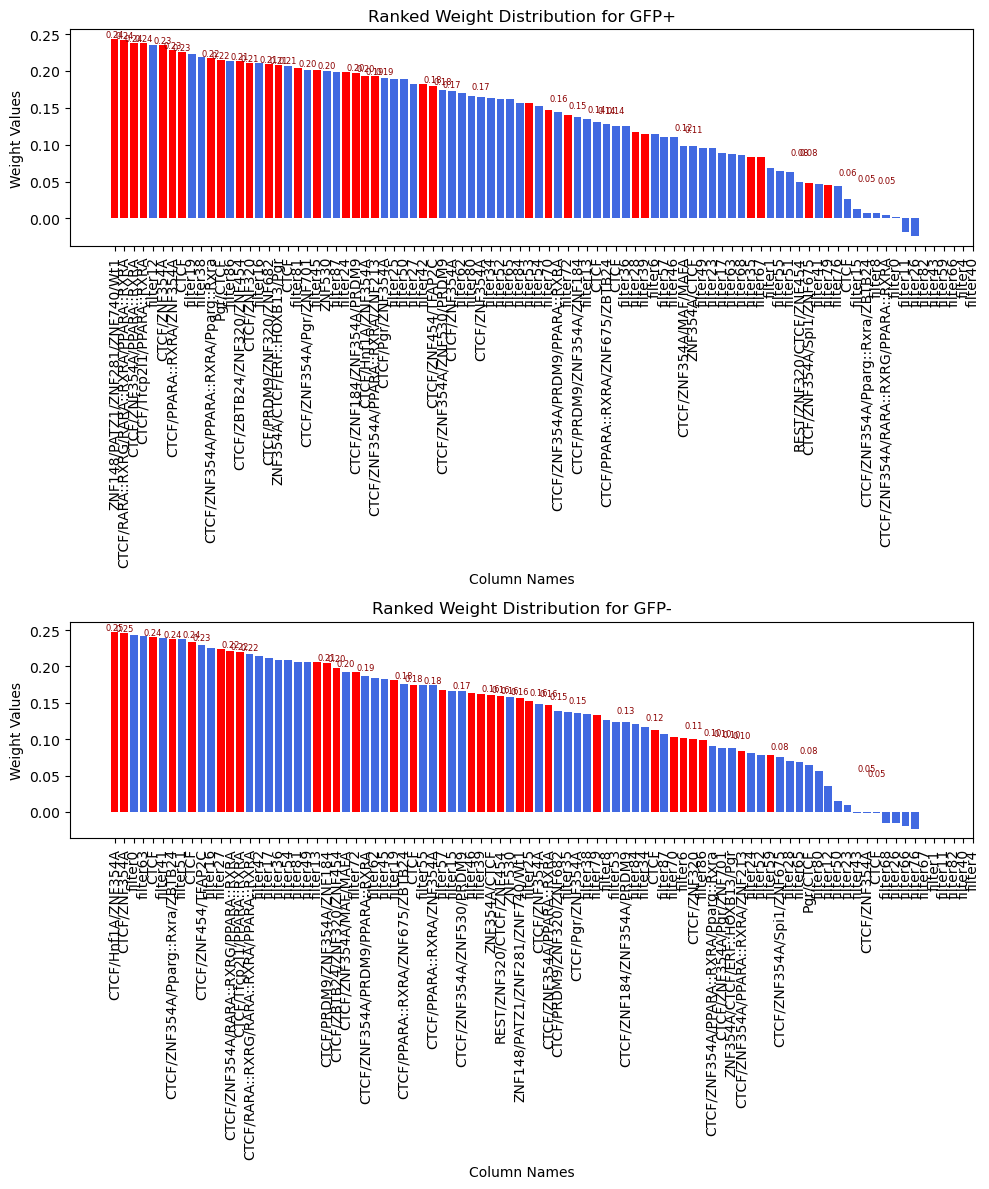

In [14]:
# Assuming weight_df is a DataFrame with multiple rows and 90 columns
num_rows = len(weight_df.index)  # Number of rows (features or categories)

# Set up a figure with subplots for each row
fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(10, 6 * num_rows))  # Adjust width and height for visibility

# Loop through each row to create a separate plot
for ax, (index, row) in zip(axes.flatten(), weight_df.iterrows()):
    # Sort the row in descending order by weight values
    sorted_row = row.sort_values(ascending=False)

    # Extract labels (column names, now sorted) and values (sorted weights)
    labels = sorted_row.index
    values = sorted_row.values

    # Define colors for the bars based on a condition (customize as needed)
    colors = ['red' if 'filter' not in label.lower() else 'royalblue' for label in labels]

    # Create the bar plot on the specific subplot axis
    ax.bar(labels, values, color=colors)

    # Label customization
    ax.set_xlabel('Column Names')
    ax.set_ylabel('Weight Values')
    ax.set_title(f'Ranked Weight Distribution for {index}')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90)  # Rotate labels to avoid overlap

    # Optionally annotate specific bars (customize as needed)
    for i, value in enumerate(values):
        if 'filter' not in labels[i].lower():
            ax.text(i, value, f'{value:.2f}', ha='center', va='bottom', color='darkred',fontsize = 6)

# Adjust layout to not overlap items
fig.tight_layout()
plt.show()




In [15]:
ann_wdf = weight_df.loc[:,["filter" not in i for i in list(weight_df)]]
ann_wdf

,CTCF/ZNF354A/PRDM9/PPARA::RXRA,CTCF/ZNF354A/MAF/MAFA,CTCF,ZNF530,CTCF,CTCF/ZNF354A/PPARA::RXRA/ZNF213,CTCF/ZNF454/TFAP2C,CTCF/ZBTB24/ZNF320/ZNF454,CTCF/ZNF354A,CTCF/PPARA::RXRA/ZNF354A,...,CTCF/ZNF184/ZNF354A/PRDM9,CTCF/ZNF320,ZNF354A/CTCF,ZNF354A/CTCF/ERF::HOXB13/Pgr,ZNF148/PATZ1/ZNF281/ZNF740/Wt1,CTCF/Pgr/ZNF354A,CTCF/PRDM9/ZNF320/ZNF682,CTCF/ZNF354A/ZNF530/PRDM9,CTCF/ZNF354A/PPARA::RXRA,CTCF/ZNF354A
GFP+,0.156073,0.116647,0.207601,0.200716,0.225288,0.193612,0.182696,0.213054,0.174937,0.228166,...,0.197945,0.210594,0.114943,0.208054,0.243101,0.192592,0.209271,0.178916,0.238347,0.172239
GFP-,0.192493,0.198193,0.237096,0.160922,0.123734,0.098929,0.233614,0.204510,0.245902,0.175140,...,0.133802,0.112031,0.163544,0.100515,0.159038,0.147046,0.152514,0.167853,0.156728,0.158236


In [16]:
# Assuming 'interpretation' and 'explainn' are already defined and properly configured
# Also assuming 'data_loader', 'device', and 'annotation' are defined as per your setup

unit_importance_GFP_pos = []
unit_importance_GFP_neg = []
unit_names = []
tf_to_filter = {}

# Loop through units with indices 0 to 4
for unit_index in range(num_cnns):
    filter_key = "filter" + str(unit_index)
    title = annotation[filter_key] if filter_key in annotation.index else filter_key
    tf_to_filter[title] = filter_key
    unit_names.append(title)  # Store the unit name for plotting
    
    # Calculate unit importance for the current unit
    unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)
    target_labels = ['GFP+','GFP-']
    importance = interpretation.get_specific_unit_importance(activations, explainn, unit_outputs, unit_index, target_labels)
    unit_importance_GFP_pos.append(importance['GFP+'])
    unit_importance_GFP_neg.append(importance['GFP-'])



['filter23', 'filter87', 'filter19', 'filter12', 'filter61', 'filter62', 'filter29', 'filter89', 'filter88', 'filter21']
['filter41', 'filter0', 'filter62', 'filter61', 'filter44', 'filter69', 'filter19', 'filter89', 'filter14', 'filter39']


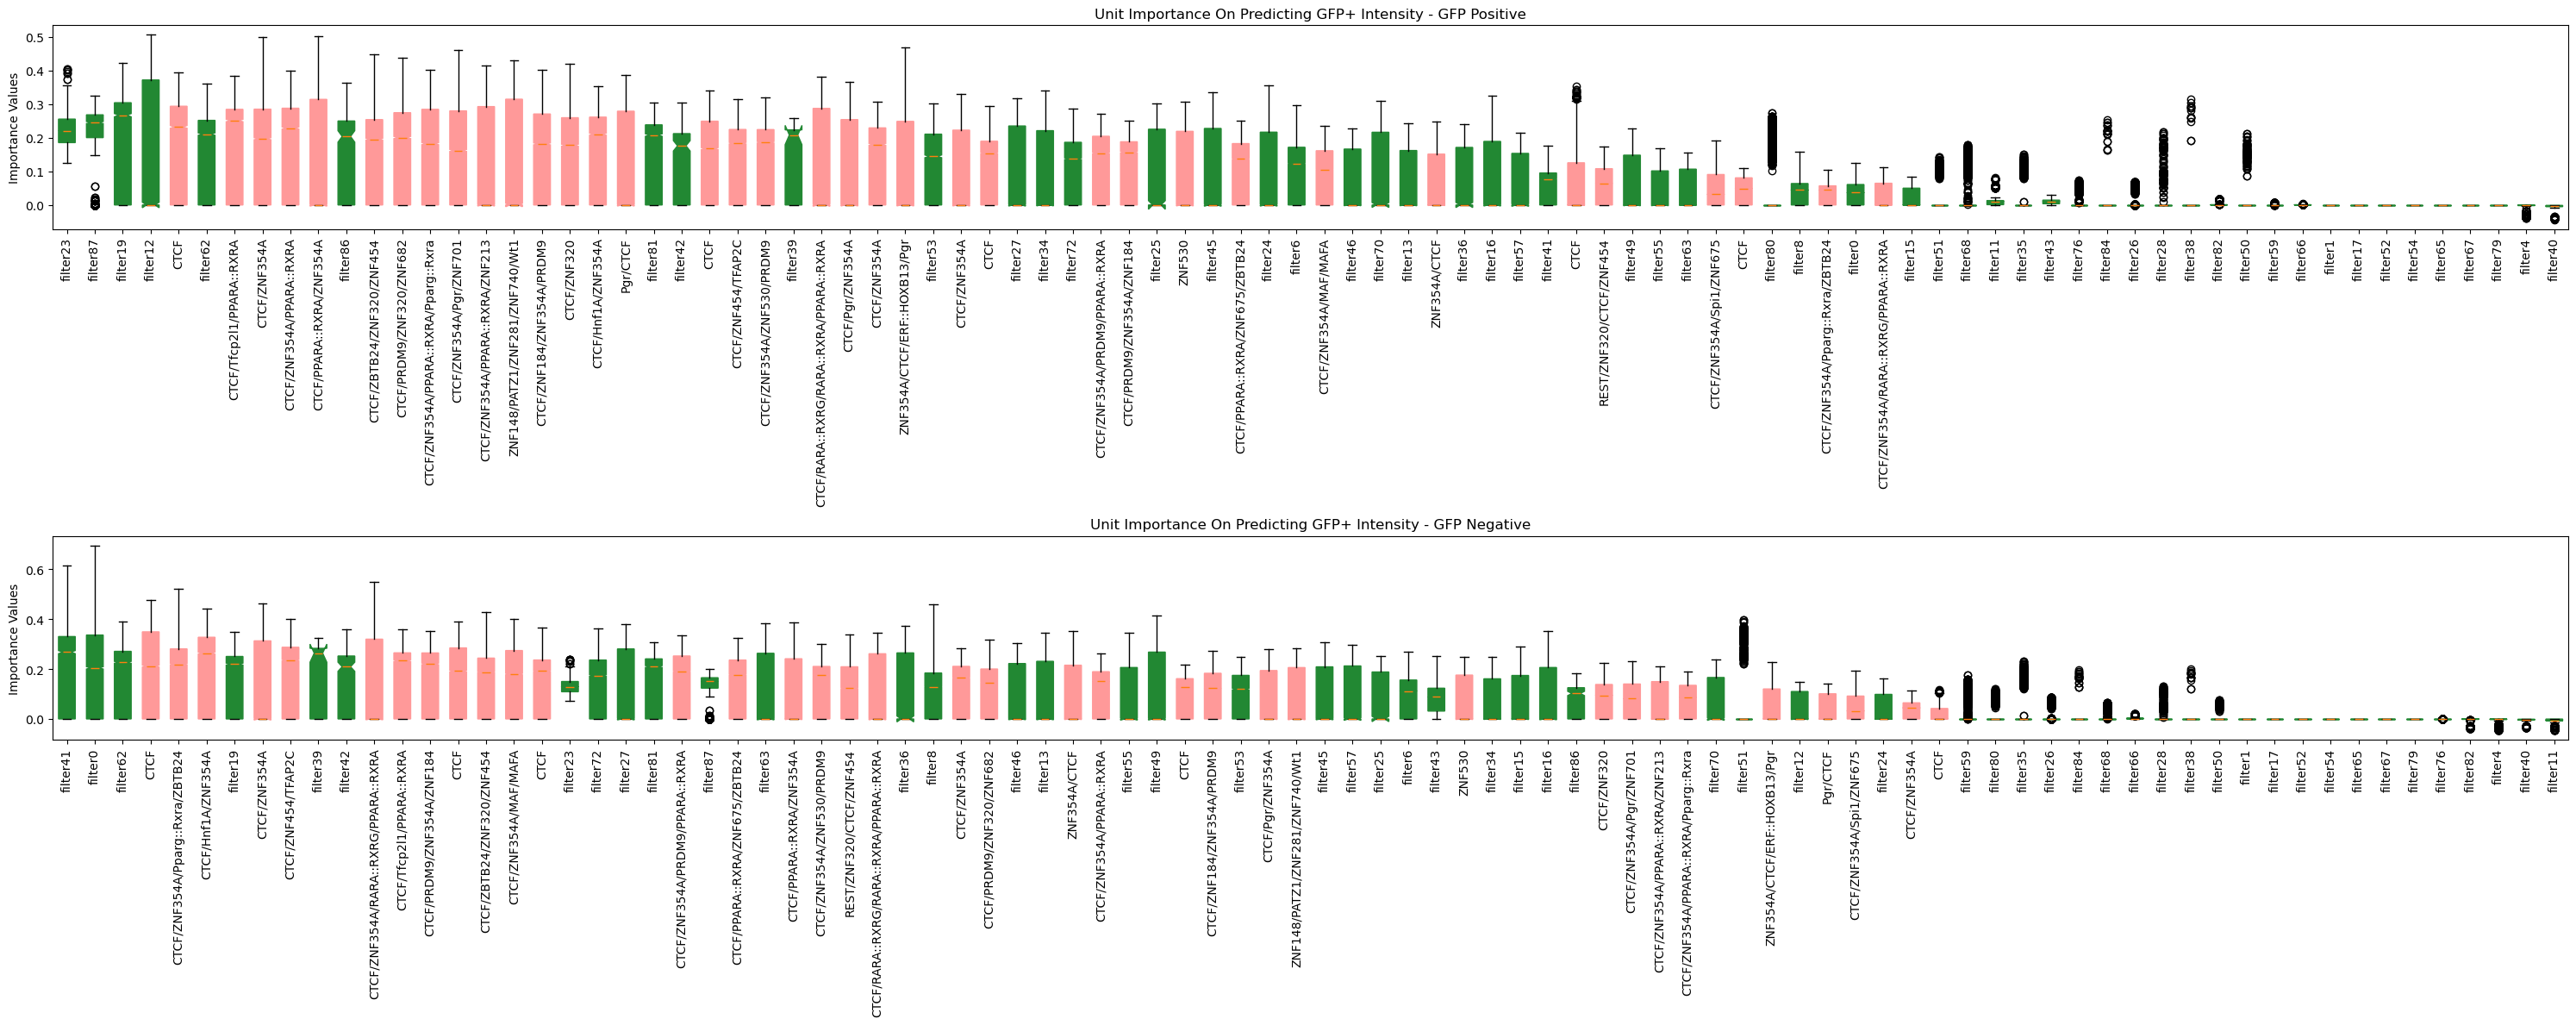

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Create a list to store common important filters
common_filters = []

# Assuming 'unit_names', 'unit_importance_GFP_pos', and 'unit_importance_GFP_neg' are defined

# Define a function to sort and plot the data
def plot_importance(ax, unit_importance_values, title_suffix):
    # Calculate the means of each list in unit_importance_values
    means = [np.mean(values) for values in unit_importance_values]

    # Create tuples of means, unit names, and values, then sort them by means
    sorted_data = sorted(zip(means, unit_names, unit_importance_values), key=lambda x: x[0], reverse=True)

    # Unzip the sorted data
    sorted_means, sorted_names, sorted_values = zip(*sorted_data)

    # Print top 10 most impoertant filters
    values_list = [tf_to_filter[name] for name in sorted_names[:10] if name in tf_to_filter]
    common_filters.append(values_list)
    print(values_list)

    # Define properties for outliers (fliers)
    flierprops = dict(marker='o', color='black', markersize=6)

    # Create box plots individually to control colors
    box_width = 0.6  # Set box width
    for i, (name, data) in enumerate(zip(sorted_names, sorted_values)):
        color = "#ff9999" if "filter" not in name.lower() else "#228833"
        ax.boxplot(data, positions=[i + 1], widths=box_width, notch=True, patch_artist=True,
                   boxprops=dict(facecolor=color, color=color), flierprops=flierprops)

    # Set custom sorted x-axis labels
    ax.set_xticks(range(1, len(sorted_names) + 1))
    ax.set_xticklabels(sorted_names, rotation=90)
    ax.set_title(f"Unit Importance On Predicting GFP+ Intensity - {title_suffix}")
    ax.set_ylabel("Importance Values")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 12))  # Adjust size as necessary

# Plot for GFP+ positive
plot_importance(ax1, unit_importance_GFP_pos, "GFP Positive")

# Plot for GFP+ negative
plot_importance(ax2, unit_importance_GFP_neg, "GFP Negative")

plt.tight_layout()
plt.show()


In [19]:
# Assuming common_filters contains exactly three lists
list1, list2 = common_filters

# Convert lists to sets and find the intersection
common_elements = set(list1) & set(list2)

# Convert the set back to a list if needed
common_elements_list = list(common_elements)

print(common_elements_list)

['filter61', 'filter89', 'filter62', 'filter19']


In [20]:

def get_specific_unit_importance(activations, model, unit_outputs, filt, target_labels):
    """
    Function to compute unit importance (unit_output*class weight) of a particular ExplaiNN unit (indexed at filt)
    :param activations: numpy.array, matrix of activations of shape (N, U, S); N - size of the dataset;
    U - number of units; S - size of the activation map
    :param model: ExplaiNN model
    :param unit_outputs: numpy.array, outputs of individual units, shape (N, U); N - size of the dataset; U - number of units;
    :param filt: int, index of the unit of interest;
    :param target_labels: a list with the names of the output nodes;
    :return: pandas.Series, contains O keys (number of ExplaiNN outputs, labels), each key contains an array of size X,
    where X is equal to the number of sequences that activated the unit of interest (indexed at filt) more than an
    activation threshold
    """

    activation_threshold = 0.5 * np.amax(activations, axis=(0, 2))
    print(f"activation_threshold shape: {activation_threshold.shape}")
    print(f"activation shape: {activations.shape}")

    # sequences (their indeces) that highly activated the filter
    res = {}
    for i in range(activation_threshold.shape[0]):
        if i != filt: continue # focus on current unit
        inds = []
        print(f"current filter is filter{filt}")
        for j in range(activations.shape[0]):
            # For 590 features at jth sample in the ith cnn, find indices of features that are activated 
            indices = np.where(activations[j, i, :] > activation_threshold[i])
            if indices[0].shape[0] > 0:
                inds.append(j)
        res[i] = inds # inds contains index of samples that have at least 1 activated feature among 590 in the specified cnn filter
    

    weights = model.final.weight.detach().cpu().numpy()  # -0.035227 0.480355
    print(f"weights shape {weights.shape}")

    res_distr = {}
    for cl in range(len(target_labels)):
        # 
        f_cell = np.multiply(unit_outputs, weights[cl])
        print(f'For label {target_labels[cl]}')
        print(f'final cell shape after multiplying cnn outputs [sample, num_cnn] with weight [1, num_cnn]: {f_cell.shape}')
        res_distr[target_labels[cl]] = f_cell[:, filt]
        print(f'interested filter final cell shape" {res_distr[target_labels[cl]].shape}')
        print(f'interested filter final cell sum" {np.sum(res_distr[target_labels[cl]])}')
        res_distr[target_labels[cl]] = res_distr[target_labels[cl]][res[filt]]
        print(f'After removing samples dont have any activated features: {res_distr[target_labels[cl]].shape}')

    res_distr = pd.Series(res_distr)

    return res_distr
# unit_outputs are the output 90 feature values for each sample from ExplaiNN linears layer (before final layer) 
unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)
print(unit_outputs.shape)
target_labels = ['GFP+','GFP-']
importance = get_specific_unit_importance(activations, explainn, unit_outputs, 19, target_labels)
print(f'importance shape: {importance.shape}')
importance

(21653, 90)
activation_threshold shape: (90,)
activation shape: (21653, 90, 590)
current filter is filter19
weights shape (2, 90)
For label GFP+
final cell shape after multiplying cnn outputs [sample, num_cnn] with weight [1, num_cnn]: (21653, 90)
interested filter final cell shape" (21653,)
interested filter final cell sum" 3121.310302734375
After removing samples dont have any activated features: (9708,)
For label GFP-
final cell shape after multiplying cnn outputs [sample, num_cnn] with weight [1, num_cnn]: (21653, 90)
interested filter final cell shape" (21653,)
interested filter final cell sum" 2568.3935546875
After removing samples dont have any activated features: (9708,)
importance shape: (2,)


GFP+    [0.3483145, 0.3412113, 0.3611168, 0.33826777, ...
GFP-    [0.2866132, 0.28076828, 0.29714766, 0.27834618...
dtype: object

filter not annotated


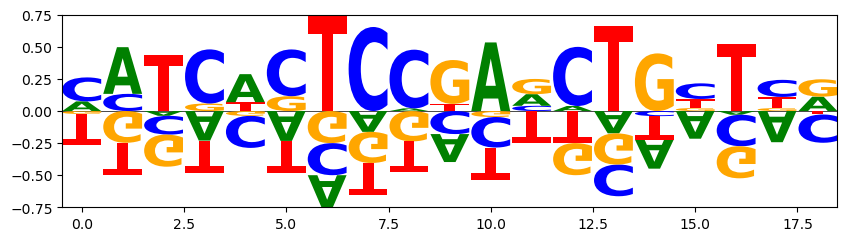

In [24]:
# Generate Motif Logos for top important filter PWMs
motifs, motif_names = tools.read_meme('/pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_both_TFBS.meme')

filterid=19
#'filter61', 'filter89', 'filter62', 'filter19'
x = [list(i) for i in motifs[filterid]]
pwm = tools._PWM_to_filter_weights(x, filter_size)
nn_logo = logomaker.Logo(pd.DataFrame(data=pwm,columns = ["A","C", "G","T"]))
if ('filter' + str(filterid)) in annotation:
    print(annotation['filter' + str(filterid)])
else:
    print("filter not annotated")

### Motif Clustering Plotting

In [25]:
# Load the similarity matrix
from scipy.cluster.hierarchy import linkage

data = np.load('/pmglocal/ty2514/Enhancer/Enhancer/tomtom_2024results/90NN_both_clustering/similarities.npz')
similarity_matrix = data['similarities']  # adjust the key if different
# Generate the linkage matrix
distance_matrix = 10.0 - similarity_matrix
Z = linkage(distance_matrix, method='complete')
Z.shape


/tmp/ipykernel_2975505/374655546.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


(89, 4)

/tmp/ipykernel_2975505/1492463901.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


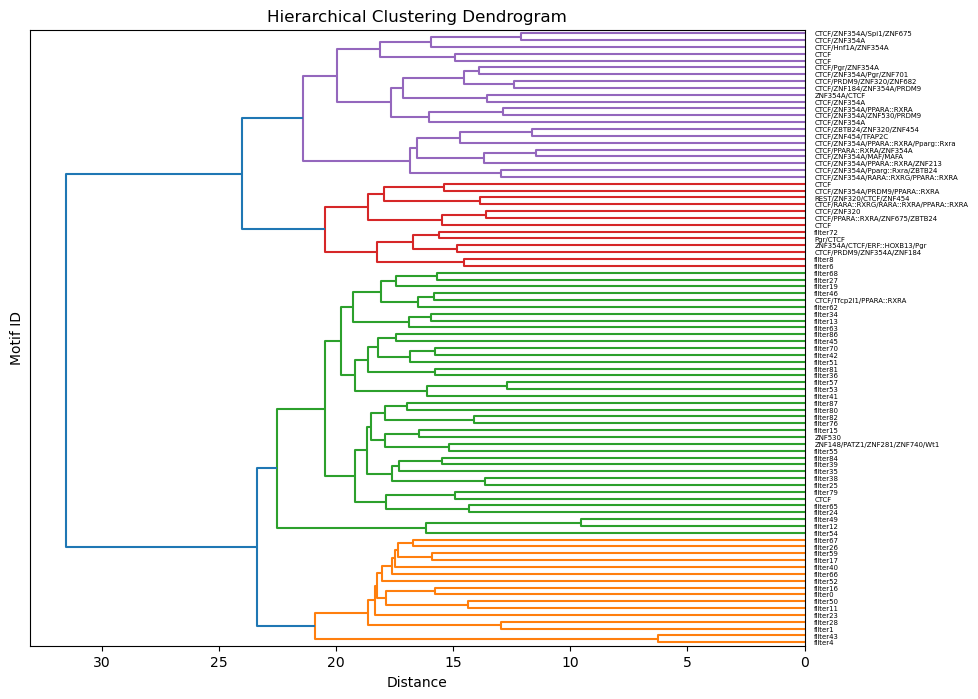

In [31]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
# Generate the linkage matrix
distance_matrix = 10.0 - similarity_matrix
Z = linkage(distance_matrix, method='complete')

# Load motif names
clusters = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/tomtom_2024results/90NN_both_clustering/clusters.tsv', sep='\t')
motif_names = clusters['Motif_ID'].values
# Replace motif names with annotated ones if the annotation exists
for i in range(len(motif_names)):
    if motif_names[i] in annotation.keys():
        motif_names[i] = annotation[motif_names[i]]

plt.figure(figsize=(10, 8))
dendrogram(Z, orientation='left', labels=motif_names, color_threshold=23)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Distance')
plt.ylabel('Motif ID')
plt.show()

/tmp/ipykernel_2975505/1031088560.py:14: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, 'ward')


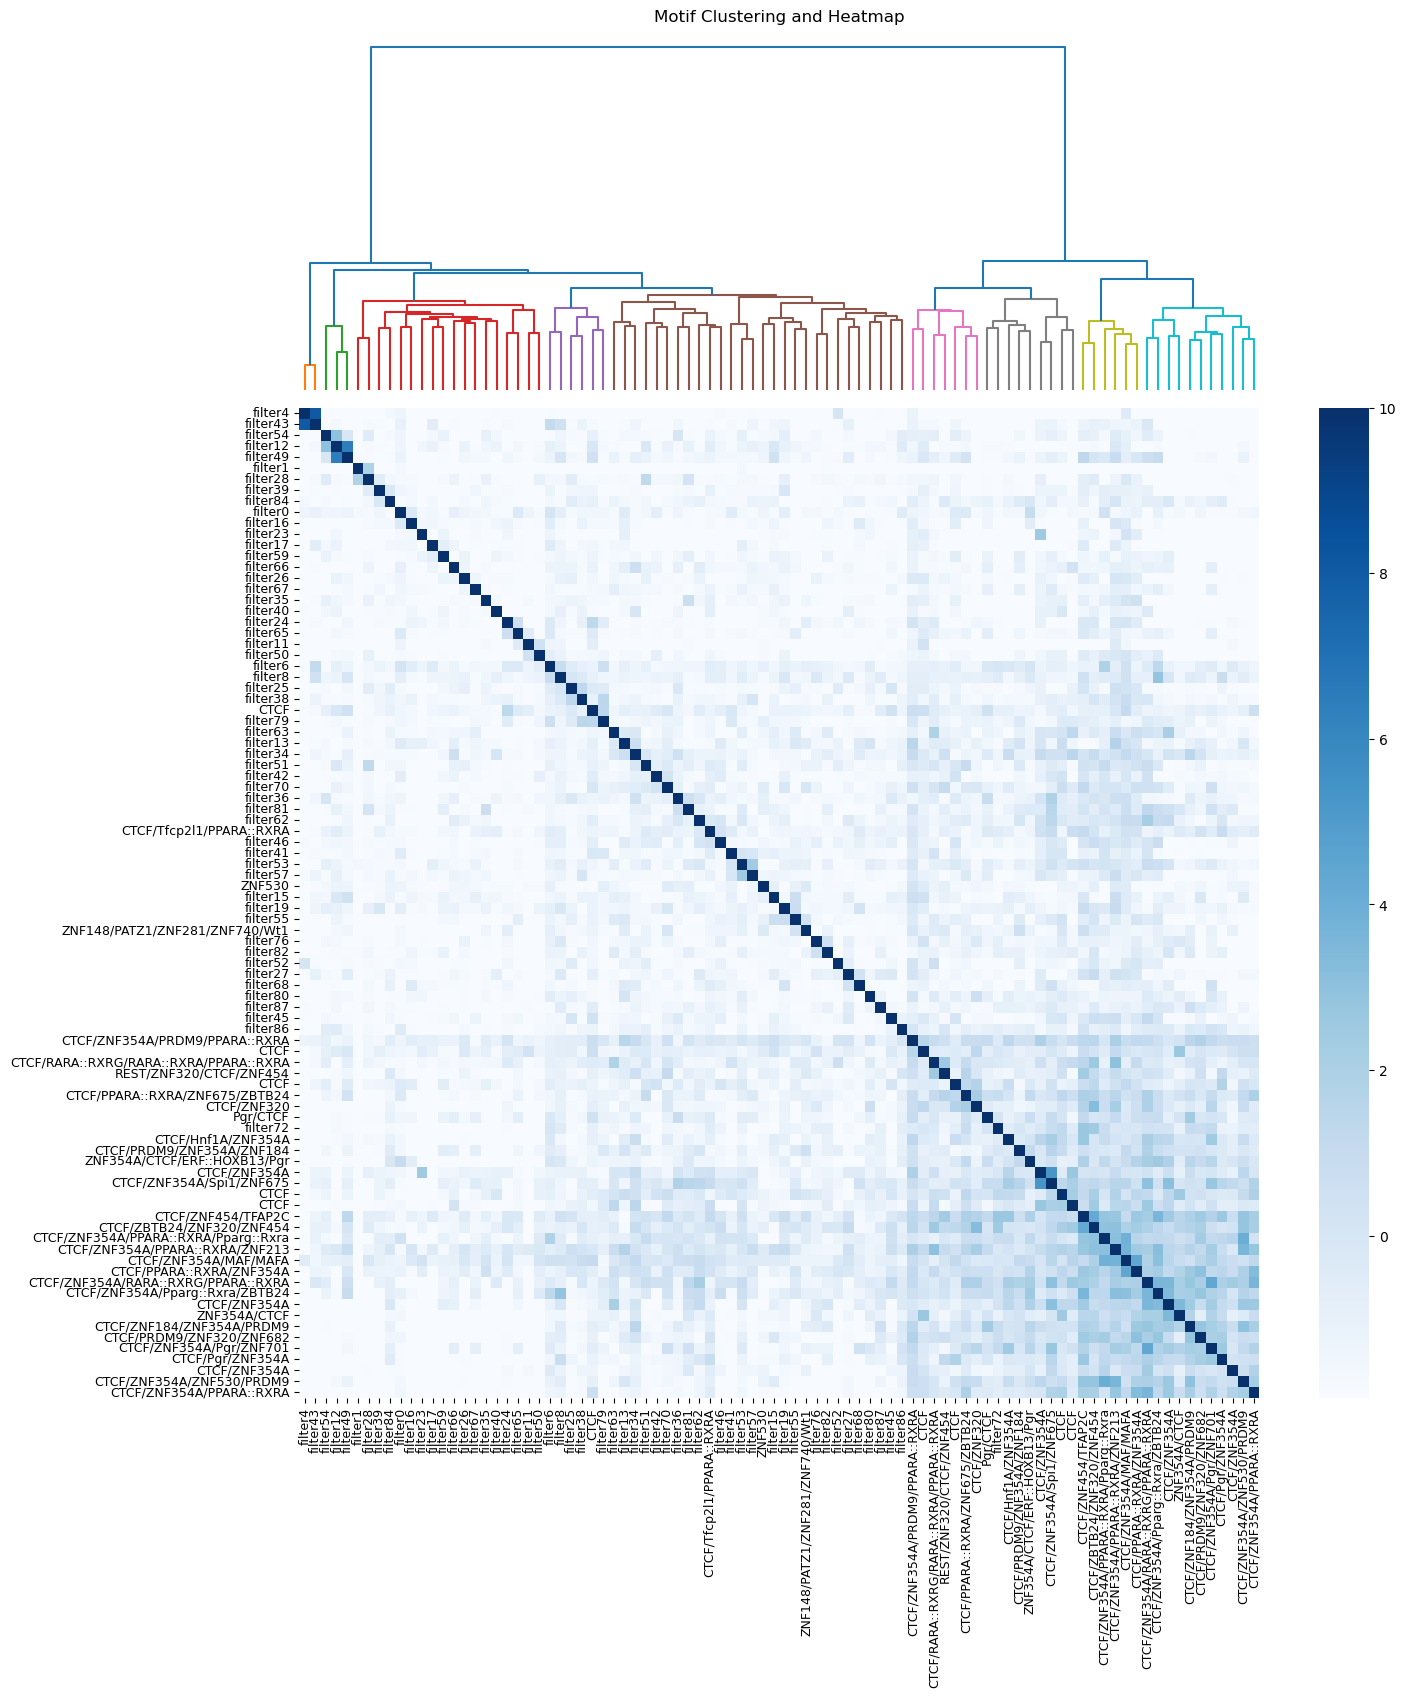

In [32]:
# Load data and process as previously described
clusters = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/tomtom_2024results/90NN_both_clustering/clusters.tsv', sep='\t')
motif_names = clusters['Motif_ID'].values

# Replace motif names with annotated ones if the annotation exists
for i in range(len(motif_names)):
    if motif_names[i] in annotation.keys():
        motif_names[i] = annotation[motif_names[i]]

# Convert similarity to distance
distance_matrix = 10 - similarity_matrix  # Assuming max value in similarity_matrix is 10

# Generate linkage matrix
Z = linkage(distance_matrix, 'ward')

# Prepare figure
fig = plt.figure(figsize=(12, 18))

# Create dendrogram on top
ax1 = fig.add_axes([0.1, 0.66, 0.8, 0.2])  # position: [left, bottom, width, height]
dendro = dendrogram(Z, orientation='top', labels=motif_names, color_threshold=25)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_title('Motif Clustering and Heatmap')


# Extract order of leaves after dendrogram
idx = dendro['leaves']

# Reorder data and labels according to dendrogram
data_ordered = similarity_matrix[idx, :][:, idx]
motif_names_ordered = np.array(motif_names)[idx]

# Create heatmap below the dendrogram
ax2 = fig.add_axes([0.1, 0.1, 1, 0.55])  # Match the horizontal positioning with dendrogram
sns.heatmap(data_ordered, ax=ax2, xticklabels=motif_names_ordered, yticklabels=motif_names_ordered, cmap='Blues')
ax2.tick_params(axis='x', rotation=90,labelsize=9)  # Rotate x labels for better visibility
ax2.tick_params(axis='y', labelsize=9)  # Rotate x labels for better visibility

plt.show()


### Annotate Cluster PWMs

In [2]:
tomtom_results = pd.read_csv("/pmglocal/ty2514/Enhancer/Enhancer/tomtom_2024results/tomtom_CAM_90NN_both_clusters/tomtom.tsv",
                                        sep="\t",comment="#")
filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]
tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]
cisbp_motifs = {}
with open("/pmglocal/ty2514/Enhancer/ExplaiNN/data/JASPAR/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt") as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            cisbp_motifs[name_m] = motif

filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]
    if len(target_id) > 5:
        target_id = target_id[:5]
    ann = "/".join([cisbp_motifs[i] for i in target_id.values])
    annotation[f] = ann

annotation = pd.Series(annotation)
annotation

cluster10                           CTCF
cluster13                         ZNF384
cluster16                          PRDM1
cluster2     KLF1/KLF7/KLF15/ZBED4/KLF10
cluster20                         ZNF816
cluster4                         ZKSCAN3
dtype: object